In [1]:
mport numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
import csv
import matplotlib.pyplot as plt
from numpy import random
from collections import defaultdict
from tqdm.notebook import tqdm
from collections import Counter
from nltk.corpus import stopwords
from pandas import DataFrame
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import operator
import string
LOG_EVERY_N= 100
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LEGION\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LEGION\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
TestQueriesdf = pd.read_csv("test-queries.tsv", sep="\t")
test_queries = TestQueriesdf.values

query_ids= test_queries[:,0]

CandPassageTopdf = pd.read_csv("candidate_passages_top1000.tsv", sep="\t")
testing_set= CandPassageTopdf.values

with open("candidate_passages_top1000.tsv", encoding= "utf8") as fp:
    top_candidate_passages_words = fp.read().split("\n")

In [3]:
def removeStopwords(wordlists, stopwords):            # function that removes stop words
    filtered_list= []
    LOG_EVERY_N= 10000
    for i in range(len(wordlists)):
        wordL= wordlists[i].lower().split()                  #Split into every word
        removal = [w for w in wordL if w not in stop_words]  # remove stopwords by Iteratively going through them
        temp=0
        temp= ' '.join(removal)
        filtered_list.append(temp)
    
    return filtered_list

In [4]:
def LemmatizeWords(wordlists):
    lemmatized_filtered_passages= []
    LOG_EVERY_N= 10000
    wordnet_lemmatizer = WordNetLemmatizer()
    for j in range(len(wordlists)):
        filteredL= wordlists[j].split()
        lemmatizing= [wordnet_lemmatizer.lemmatize(word) for word in filteredL]
        temp = 0
        temp= ' '.join(lemmatizing)
        lemmatized_filtered_passages.append(temp)
    return lemmatized_filtered_passages

In [5]:
def removepunct(wordlists): 
    no_punct_list= []
    LOG_EVERY_N= 10000
    for i in range(len(wordlists)):
        wordL= wordlists[i].lower()                 #Split into every word
        removal = wordL.translate(str.maketrans('', '', string.punctuation))
        no_punct_list.append(removal)   
    return no_punct_list

In [6]:
stop_words= stopwords.words('english')

In [7]:
def GenerateNRanking(total_list,N,passages_id_per_query,query_ids):
    N=100
    total_qid= []
    total_pids= []
    total_scores= []
    total_doc_indices = []
    
    for qu in range(len(total_list)):          # For every Query
        scores = []
        qid= []
        pids = []
        list1= list(total_list[qu,:])       # Get the scores
        for i in range(0,N):                # Find top 100 scores
            max1= np.max(list1)
            if (max1==-100 or max1== 0):
                list1.remove(max1)
                scores.append(["NaN"])
                pids.append(["NaN"])
                qid.append(["NaN"]) 
            else:
                document_index= 0
                document_index= list(list1).index(max1)
                list1.remove(max1)
                scores.append(max1)
                pids.append(passages_id_per_query[qu][document_index])
                qid.append(query_ids[qu])
        total_scores.append(scores)
        total_pids.append(pids)
        total_qid.append(qid)
    return total_scores,total_qid, total_pids


In [8]:
def SaveFile(total_scores,total_qid,total_pids,algo):
    
    
    qids= np.array(total_qid)
    qids=qids.reshape((qids.shape[0]*qids.shape[1],1))
    
    pids= np.array(total_pids)
    pids= pids.reshape((pids.shape[0]*pids.shape[1],1))
    
    scores= np.array(total_scores)
    scores=scores.reshape((scores.shape[0]*scores.shape[1],1))
    
    
    
    algor= np.full((qids.shape[0], 1), algo) 
    watermark= np.full((qids.shape[0], 1), "A2")                 #Watermark
      
    ranking= np.array((range(1,len(total_pids[0])+1)))
    ranklist = []
    for x in range(len(total_pids)):
        ranklist.append(ranking)  
        
    rank = np.array(ranklist)  
    rank = rank.reshape((rank.shape[0]*rank.shape[1],1))
    
    with open('%s.txt' % algo,'w+') as f:
        writer= csv.writer(f,)
        writer.writerows(zip(qids,watermark,pids,rank,scores,algor))

We start by importing back the testing set and pre-processing it:

In [9]:
temp_testing_q=removepunct(test_queries[:,1])
lemmed_filtered_test_queries= removeStopwords(temp_testing_q, stop_words)
testing_lemmed_filtered_test_queries=LemmatizeWords(lemmed_filtered_test_queries)


query_ids= test_queries[:,0]
temp= []
testing_filtered_passages_per_query= []
testing_passages_id_per_query= []
temp_testing_p = []
for j in range(len(query_ids)):
    indices = [i for i, x in enumerate(testing_set[:,0]) if x == query_ids[j]]
    temp_passages=testing_set[indices,3]
    temp_id= testing_set[indices,1]
    temp_testing_p.append(removepunct(temp_passages))
    temp2_testing_p= removeStopwords(temp_testing_p[j], stop_words)
    temp3_passages= LemmatizeWords(temp2_testing_p)
    testing_filtered_passages_per_query.append(temp3_passages)
    testing_passages_id_per_query.append(temp_id)

In this part, we implement the BM25 again on the new validation dataset.

In [10]:
Validation = pd.read_csv("validation_data.tsv", sep="\t")
validation_set= Validation.values

Training = pd.read_csv("train_data.tsv", sep="\t")
training_data = Training.values

In [11]:
relevant_docs = [x for x in training_data[:,4] if x==1]
len(relevant_docs)
training_data[0,3]

'Watch portion sizes: ■ Even healthy foods will cause high blood sugar if you eat too much. ■ Make sure each of your meals has the same amount of CHOs. Avoid foods high in sugar: ■ Some foods to avoid: sugar, honey, candies, syrup, cakes, cookies, regular soda and.'

In [12]:
valid_queries_id= list(Counter(validation_set[:,0]).keys())                         
no_of_docs_per_given_valid_query= list(Counter(validation_set[:,0]).values()) 

In [13]:
valid_queries= list(Counter(validation_set[:,2]).keys())                              # Finding a list of all unique queries

In [14]:
subset_validation_queries= valid_queries[:]
subset_validation_query_ids= valid_queries_id[:]

In [15]:
temp_validation_q= removepunct(subset_validation_queries[:])                     # in the interest of time
temp2_validation_q=removeStopwords(temp_validation_q, stop_words)        # currently only looking for the first 10 queries 
clean_filtered_valid_queries=LemmatizeWords(temp2_validation_q)

In [16]:
clean_valid_passages_for_queries = []
validation_passages_id_for_queries = []
temp_validation_p = []
for i in range(len(subset_validation_queries[:])):
    temp_passages_id=validation_set[validation_set[:,0]==subset_validation_query_ids[i],1]
    validation_passages_id_for_queries.append(temp_passages_id)
    temp_passages= validation_set[validation_set[:,0]==subset_validation_query_ids[i],3]
    temp_validation_p.append(removepunct(temp_passages))
    temp2_validation_p= removeStopwords(temp_validation_p[i], stop_words)
    temp3_passages= LemmatizeWords(temp2_validation_p)
    clean_valid_passages_for_queries.append(temp3_passages)
    

In [17]:
validation_passages= validation_set[0:1000,3]
validation_passages=removepunct(validation_passages)
validation_passages=removeStopwords(validation_passages,stop_words)
unordered_validation_passages=LemmatizeWords(validation_passages)

validation_queries= validation_set[0:1000,2]
validation_queries=removepunct(validation_queries)
validation_queries=removeStopwords(validation_queries,stop_words)
unordered_validation_queries=LemmatizeWords(validation_queries)

Build the inverted index again

In [18]:
InvIndx= dict({qid: { } for qid in subset_validation_query_ids[:]})
for i in range(len(subset_validation_query_ids[:])):
    query_words= clean_filtered_valid_queries[i].split()
    for j in range(len(clean_valid_passages_for_queries[i])):
        check = clean_valid_passages_for_queries[i][j]     
        for item in query_words: 
            if item in check:
                occurance=check.count(item)
                if item not in InvIndx[subset_validation_query_ids[i]]:
                    InvIndx[subset_validation_query_ids[i]][item] = []    
                if item in InvIndx[subset_validation_query_ids[i]]:
                    InvIndx[subset_validation_query_ids[i]][item].append(validation_passages_id_for_queries[i][j])
                InvIndx[subset_validation_query_ids[i]][item].append(occurance) 

In [19]:
BM25= np.zeros((len(clean_valid_passages_for_queries),len(clean_valid_passages_for_queries[0])))

words = ''.join(str(clean_valid_passages_for_queries[:][:])).split()

no_of_words= len(words)

vocab_size= len(list(InvIndx.fromkeys(words))) 

no_of_documents = len(clean_valid_passages_for_queries) * len(clean_valid_passages_for_queries[0])

average_doc_length =  no_of_words / no_of_documents

k1= 1.2
k2= 100
b=0.75
print(average_doc_length)

32.78459668989547


In [20]:
for q in range(len(clean_valid_passages_for_queries)):                 # Iterating Through each query
    N_total= len(clean_valid_passages_for_queries) * len(clean_valid_passages_for_queries[q])            #Total Number of documents in collection
    words_in_query= list(InvIndx[subset_validation_query_ids[q]].keys())       # Find the words available for every query
    
    for d in range(len(clean_valid_passages_for_queries[q])):                     #Iterating through every document
        
        doc_len= len(clean_valid_passages_for_queries[q][d].split())
        query_len= len(words_in_query) 
        doc_id= validation_passages_id_for_queries[q][d]                                         # getting the document id
        K= k1* ((1-b) + (b * ((doc_len)/average_doc_length)))
        
        summation_BM = 0
        ri = 0
        R = 0
        
        for t in range(len(words_in_query)):                   #For each word in the query  
            
            values= list(InvIndx[subset_validation_query_ids[q]][words_in_query[t]])  #Inverted index for term position and frequency
            nt= int(len(values)/2)                              # how many docs has it occured in
            
            num1=0.5 + ri
            denum1=R - ri + 0.5
            num2= nt - ri + 0.5
            denum2=N_total - nt - R + ri + 0.5
            
            if doc_id in values:    
                tf = values[values.index(doc_id) + 1]                       # Term frequency in that document
                
                try:
                    product1_BM= np.log((num1/denum1) / (num2/denum2))                             #First Part od BM
                except ZeroDivisionError:
                    product1_BM = 1                              # 1 as its a log
                
                product2_BM= ((k1+1) * tf) / (K+tf)
                product3_BM= ((k2+1)*words_in_query.count(words_in_query[t])) / (k2+words_in_query.count(words_in_query[t]))
                 
                Product_BM= product1_BM * product2_BM * product3_BM 
                
            else:
                # If terms are not seen
                Product_BM=0
            
            summation_BM+= Product_BM 
                
        BM25[q,d]=summation_BM

In [21]:
#BM25
N=100
top_scores,top_qids,top_pids = GenerateNRanking(BM25,N,validation_passages_id_for_queries,subset_validation_query_ids)

Subtask 1: We find MAP and MnDCG for using the BM25

In [119]:
def GetMetrics(validation_set,top_qids,top_pids):
    average_precision_lst = []
    ndcg_lst= []
    
    for q in range(len(top_qids)):            # For each query
        #if q%100==0:
        #    print("iteration number: %i" %q,"out of %i" %len(top_qids))
        # Variables needed for computing MAP
        count=0
        precision = []
        # Variables needed for computing NDCG
        dcg = 0
        idcg=0
        data_per_query= validation_set[validation_set[:,0]==top_qids[q][0],:] # blocks of data/documents per query
        no_of_relevancies= Counter(data_per_query[:,4])                       # count number of positive and neg relevancies
        no_of_positive_relevancies=no_of_relevancies[1]                        # get number of positive relevancies 
        
        #Calculating IDCG
        for I in range(no_of_positive_relevancies):
            num_idcg= 1
            denum_idcg= np.log2(I+2)
            idcg+= num_idcg/denum_idcg
                    
        for n in range(len(top_pids[q])):
            relevancy = data_per_query[data_per_query[:,1]==top_pids[q][n],4]
            
            #Calculating DCG
            if relevancy.size > 0:
                num_dcg = (2 **(relevancy)) - 1
                denum_dcg =  np.log2(n+2)
                dcg+= num_dcg/denum_dcg
            else:
                dcg+=0  
            
            #Computing MAP
            if (relevancy.size>0 and relevancy==1):
                #print("query number: ", q)
                #print("relevant document ranking: ", n)
                count+=1
                precision.append(count/(n+1))
                
        # finding mean average precision over queries
        if not precision:
            average_precision=0
        else:
            average_precision= np.mean(precision)
        
        average_precision_lst.append(average_precision)
        #finding mean NDCG over queries
        if idcg!=0:
            ndcg= dcg/idcg
            ndcg_lst.append(ndcg)
    
    MAP= np.mean(average_precision_lst) 
    MnDCG= np.mean(ndcg_lst)
    
    return MAP,MnDCG

In [23]:
MAP,MnDCG= GetMetrics(validation_set,top_qids,top_pids)

In [24]:
MAP

0.14879101410952542

In [25]:
MnDCG

0.1960943891018742

In [26]:
Compare= 4


print("Query: ")
print(np.unique(validation_set[np.where(validation_set[:,0]==top_qids[Compare][0]),2]))
print("\n")
print("Top BM25 on txt file: ")
print(np.unique(validation_set[np.where(validation_set[:,1]==top_pids[Compare][0]),3]))

Query: 
['who discovered the element carbon']


Top BM25 on txt file: 
['The element carbon was discovered by the Egyptians or Sumerians. They discovered one elemental form of carbon- charcoal. Other elemental forms are graphite and diamond. Chemical analysis of these forms of carbon was not done until the 18th century. Antoine Lavoisier was the first to list carbon as an element in 1789.']


Subtask 2: Logistic Regression

Part 1: Creating the Word2Vec Model using a subset of the training data

In [27]:
import gensim
import gensim.downloader
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
#corpus = api.load('text8')
#Model = Word2Vec(corpus)

In [28]:
model = gensim.downloader.load('word2vec-google-news-300')

In [29]:
### training_data[0,3]               #Explain in report
training_data = training_data[1:,:]

In [30]:
unique_training_query_id = list(Counter(training_data[:,0]).keys())

In [31]:
unique_training_queries = list(Counter(training_data[:,2]).keys())

In [32]:
#Performing Negative Sampling
start= time.time()
sampled_passages = []
sampled_queries = []
sampled_queries_id = []
sampled_relevs= []
for q in range(len(unique_training_query_id)): 
    if q%500==0:
        print("iteration no: %i" %q,"out of %i" %len(unique_training_query_id))

    data_per_training_query=training_data[training_data[:,0]==unique_training_query_id[q],:]

    negative_data_per_query=  list(data_per_training_query[data_per_training_query[:,4]==0,:])

    positive_data_per_query= list(data_per_training_query[data_per_training_query[:,4]==1,:])

    tosample_data= np.array(negative_data_per_query[0:10*len(positive_data_per_query)] + positive_data_per_query)

    sampled_passages.extend(tosample_data[:,3])
    sampled_queries.extend(tosample_data[:,2])
    sampled_queries_id.extend(tosample_data[:,0])
    sampled_relevs.extend(tosample_data[:,4])

end = time.time()
print(end-start)

iteration no: 0 out of 4590
iteration no: 500 out of 4590
iteration no: 1000 out of 4590
iteration no: 1500 out of 4590
iteration no: 2000 out of 4590
iteration no: 2500 out of 4590
iteration no: 3000 out of 4590
iteration no: 3500 out of 4590
iteration no: 4000 out of 4590
iteration no: 4500 out of 4590
270.2920536994934


In [33]:
temp_q= removepunct(sampled_queries)  
temp2_q=removeStopwords(temp_q, stop_words)                 
filtered_sampled_queries=LemmatizeWords(temp2_q)

In [34]:
temp_p=removeStopwords(sampled_passages, stop_words) 
temp2_p= removepunct(temp_p)                    
filtered_sampled_passages=LemmatizeWords(temp2_p)

In [35]:
def GetEmbeddings(model,sentences,temp_q):  #One list of sentences
    all_words= [w.split() for w in sentences]                     #List of List
    _vector= np.zeros((len(sentences),300))
    for n in range(len(sentences)):
        #if (n!=0 and n%100==0):
        #    print("iteration number: %i" %n,"out of %i" %len(sentences))
        _embedding= []
        for j in range(len(all_words[n])):
            try:
                temp_vec= model[all_words[n][j]]
            except KeyError as e:  
                if (not _embedding and j==len(all_words[n])-1):  # if the only word in the query is not present
                    unremoved= temp_q[n].split()                                     #find removed stopwords and uses them
                    for J in range(len(unremoved)):
                        try:
                            TEMP_VEC= model[unremoved[J]]
                        except KeyError as e:
                            if (not _embedding and J==len(unremoved)-1):
                                _embedding.append(np.zeros(300))   
                            continue
                        _embedding.append(TEMP_VEC)
                continue   
            _embedding.append(temp_vec)
    
        _vector[n,:] = np.mean(_embedding,axis=0)
    
    return _vector

In [36]:
query_vector = GetEmbeddings(model,filtered_sampled_queries,temp_q)

In [37]:
passage_vector = GetEmbeddings(model,filtered_sampled_passages,temp_p)

In [38]:
sampled_training_features = abs(query_vector - passage_vector)
sampled_training_features_600 = np.hstack((query_vector,passage_vector))

In [39]:
sampled_training_features.shape

(52615, 300)

Part 2: Implement the Logistic Regression

In [40]:
def sigmoid(o):
    return 1/(1+np.exp(-o))

In [41]:
obs= np.array(sampled_relevs).astype(None)    # observations (relevance values)
observations = obs.reshape((len(obs), 1))

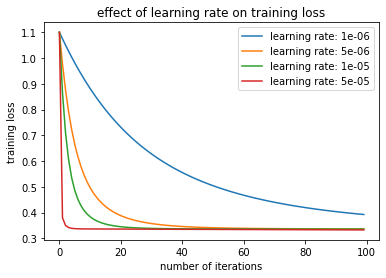

In [53]:
lr= [1e-6,5e-6,1e-5,5e-5]
fig, ax = plt.subplots()
all_weights = []
inital_weights = np.random.randn(300,1)
for l in lr:
    weights= inital_weights
    itr=0
    loss = []
    for y in range(100): # Continue until converge criterion is met

        sig=sigmoid(sampled_training_features@weights)

        prod1= observations * np.log(sig)

        prod0 = (1-observations) * (np.log(1 - sig))

        curr_loss = (-1/sampled_training_features.shape[0]) * np.sum(prod1 + prod0)
        loss.append(curr_loss)

        gradient_loss= -(sampled_training_features.T@(observations-sig))

        previous_w= weights
        weights = weights - (l * gradient_loss)
        itr+=1
        if itr==10000:
            break
    all_weights.append(weights)
    ax.plot(loss, label="learning rate: "+ str(l))
    plt.legend(['A simple line'])
plt.title("effect of learning rate on training loss")
plt.xlabel("number of iterations")
plt.ylabel("training loss")
ax.legend()
plt.show()

Part 3: Logistic Regression on the validation set

There are 1,148 unique queries in the validation set, and roughly 1,000 passage per given query. i.e(1,103,039 points)

In [43]:
validation_query_vectors = GetEmbeddings(model,clean_filtered_valid_queries,temp_validation_q)
#validation_query_vectors = GetEmbeddings(model,temp_validation_q,temp_validation_q)

In [44]:
testing_query_vectors = GetEmbeddings(model,testing_lemmed_filtered_test_queries,temp_testing_q)

In [45]:
Validation_LogReg= np.zeros((len(clean_filtered_valid_queries),len(clean_valid_passages_for_queries[0])))

In [54]:
all_metrics= []
for w in all_weights:
    for q in range(len(clean_filtered_valid_queries)):                 # Iterating Through each query
        if q%500==0:
            print("iteration number: %i" %q,"out of %i" %len(clean_filtered_valid_queries))

        validation_passage_vectors = GetEmbeddings(model,temp_validation_p[q],temp_validation_p[q])


        validation_features= abs(validation_query_vectors[q] - validation_passage_vectors)

        y_hat = sigmoid(validation_features@w)
        y_hat = y_hat.reshape((len(y_hat)))
        Validation_LogReg[q,0:validation_passage_vectors.shape[0]]= y_hat 
    N=100
    V_top_scores_LR,V_top_qids_LR,V_top_pids_LR = GenerateNRanking(Validation_LogReg,N,validation_passages_id_for_queries,subset_validation_query_ids)
    MAP_LR,MnDCG_LR= GetMetrics(validation_set,V_top_qids_LR,V_top_pids_LR)
    all_metrics.append(MnDCG_LR)
    print(MAP_LR)
    print(MnDCG_LR)

iteration number: 0 out of 1148
iteration number: 500 out of 1148
iteration number: 1000 out of 1148
0.00841547814272662
0.028653939702829652
iteration number: 0 out of 1148
iteration number: 500 out of 1148
iteration number: 1000 out of 1148
0.009460606926325455
0.03061571797995889
iteration number: 0 out of 1148
iteration number: 500 out of 1148
iteration number: 1000 out of 1148
0.009724361440559418
0.030349823498459227
iteration number: 0 out of 1148
iteration number: 500 out of 1148
iteration number: 1000 out of 1148
0.009158314766348473
0.03015896332171011


In [55]:
for q in range(len(clean_filtered_valid_queries)):                 # Iterating Through each query
    if q%500==0:
        print("iteration number: %i" %q,"out of %i" %len(clean_filtered_valid_queries))

    validation_passage_vectors = GetEmbeddings(model,temp_validation_p[q],temp_validation_p[q])


    validation_features= abs(validation_query_vectors[q] - validation_passage_vectors)

    y_hat = sigmoid(validation_features@all_weights[np.argmax(all_metrics)])
    y_hat = y_hat.reshape((len(y_hat)))
    Validation_LogReg[q,0:validation_passage_vectors.shape[0]]= y_hat 
N=100
V_top_scores_LR,V_top_qids_LR,V_top_pids_LR = GenerateNRanking(Validation_LogReg,N,validation_passages_id_for_queries,subset_validation_query_ids)
MAP_LR,MnDCG_LR= GetMetrics(validation_set,V_top_qids_LR,V_top_pids_LR)
print(MAP_LR)
print(MnDCG_LR)

iteration number: 0 out of 1148
iteration number: 500 out of 1148
iteration number: 1000 out of 1148
0.009460606926325455
0.03061571797995889


In [56]:
#LogReg
N=100
V_top_scores_LR,V_top_qids_LR,V_top_pids_LR = GenerateNRanking(Validation_LogReg,N,validation_passages_id_for_queries,subset_validation_query_ids)

In [93]:
MAP_LR,MnDCG_LR= GetMetrics(validation_set,V_top_qids_LR,V_top_pids_LR)

query number:  6
relevant document ranking:  81
query number:  10
relevant document ranking:  97
query number:  26
relevant document ranking:  61
query number:  31
relevant document ranking:  2
query number:  32
relevant document ranking:  67
query number:  33
relevant document ranking:  49
query number:  33
relevant document ranking:  99
query number:  51
relevant document ranking:  83
query number:  73
relevant document ranking:  88
query number:  75
relevant document ranking:  30
query number:  78
relevant document ranking:  68
query number:  86
relevant document ranking:  0
query number:  120
relevant document ranking:  63
query number:  120
relevant document ranking:  85
query number:  127
relevant document ranking:  11
query number:  138
relevant document ranking:  35
query number:  144
relevant document ranking:  3
query number:  145
relevant document ranking:  5
query number:  155
relevant document ranking:  45
query number:  184
relevant document ranking:  72
query number:  20

In [61]:
MAP_LR

0.009460606926325455

In [62]:
MnDCG_LR

0.03061571797995889

In [82]:
len(V_top_qids_LR)

1148

In [97]:
Compare= 86


print("Query: ")
print(np.unique(validation_set[np.where(validation_set[:,0]==V_top_qids_LR[Compare][0]),2]))
print("\n")
print("Top BM25 on txt file: ")
print(np.unique(validation_set[np.where(validation_set[:,1]==V_top_pids_LR[Compare][0]),3]))

Query: 
['ithaca teachers salaries']


Top BM25 on txt file: 
['Elementary School Teacher in Ithaca, New York Salary An Elementary School Teacher in Ithaca, New York earns an average salary of $56,074 per year. $44,362 - $68,000']


Running against the test queries and saving the file:

In [99]:
testing_LR= np.zeros((len(testing_filtered_passages_per_query),len(testing_filtered_passages_per_query[0])))

for q in range(len(testing_filtered_passages_per_query)): 
    
    testing_passage_vectors = GetEmbeddings(model,testing_filtered_passages_per_query[q],temp_testing_p[q])
    
             
    testing_features= abs(testing_query_vectors[q] - testing_passage_vectors)
    
    #V_Q= np.tile(testing_query_vectors[q],(testing_passage_vectors.shape[0],1))
    #testing_features_600= np.hstack((V_Q,validation_passage_vectors))

    y_hat = sigmoid(testing_features@weights)
    y_hat = y_hat.reshape((len(y_hat)))
    testing_LR[q,0:testing_passage_vectors.shape[0]]= y_hat 

In [100]:
N=100
top_scores_LR,top_qids_LR,top_pids_LR = GenerateNRanking(testing_LR,N,testing_passages_id_per_query,query_ids)

In [101]:
Compare= 11

print("Query: ")
print(test_queries[np.where(test_queries[:,0]==top_qids_LR[Compare][0]),1])
print("\n")
print("Top NN on txt file: ")
print(testing_set[np.where(testing_set[:,1]==top_pids_LR[Compare][0]),3])

Query: 
[["sop's policy"]]


Top NN on txt file: 
[['SOP, at standard operating procedure; sop up something; sop sth up; SOP, at statement of principles']]


In [102]:
SaveFile(top_scores_LR,top_qids_LR,top_pids_LR,"LR")

<ipython-input-8-a2db46748247>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  qids= np.array(total_qid)
<ipython-input-8-a2db46748247>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pids= np.array(total_pids)
<ipython-input-8-a2db46748247>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scores= np.array(total_scores)


SubTask 3: Implementation of the LambdaMART Model 

In [103]:
import xgboost as xgb

In [104]:
max_depth= range(1,10)
eta = np.linspace(0.1,0.5,10)
num_round = range(1,10)

In [105]:
xg_training_relevancy = np.array(sampled_relevs)
xg_training = xgb.DMatrix(sampled_training_features, label=xg_training_relevancy)

In [106]:
xg_validation_relevancy = validation_set[0:1000,4]          # only used 1,000 values for validation 

xg_validation_q_vectors = GetEmbeddings(model,unordered_validation_queries,temp_q)
xg_validation_p_vectors = GetEmbeddings(model,unordered_validation_passages,temp_p)
xg_validation_features = abs(xg_validation_q_vectors - xg_validation_p_vectors)

xg_validation = xgb.DMatrix(xg_validation_features, label=xg_validation_relevancy)

Cross-Validation

In [110]:
Validation_LambdaMart = np.zeros((len(clean_filtered_valid_queries),len(clean_valid_passages_for_queries[0])))
evallist = [(xg_validation, 'eval'), (xg_training, 'train')]

In [122]:
#evallist = [(xg_validation, 'eval'), (xg_training, 'train')]
#LM_MAP_plotting = []
#LM_MnDCG_plotting = []

#With MAP evaluation
#counter=0
#for e in eta:
#    for m in max_depth:
#        for n in num_round:
        #    param = {'max_depth':m, 'eta':e, 'objective':'rank:pairwise', 'eval_metric':'map'}
        #    print("Using maximum depth as %i" %m," and step size shrinkage as %.3f" %e)
        #    LM_model = xgb.train(param, xg_training,n,evallist)

        #    for q in range(len(clean_filtered_valid_queries)):                 # Iterating Through each query 
                #if q%250==0:
                #    print("iteration number: %i" %q,"out of %i" %len(clean_filtered_valid_queries))

        #        validation_passage_vectors = GetEmbeddings(model,clean_valid_passages_for_queries[q],temp_validation_p[q])

        #        validation_features= abs(validation_query_vectors[q] - validation_passage_vectors)  
        #        xg_y_hat = xgb.DMatrix(validation_features)

        #        y_hat = LM_model.predict(xg_y_hat)

        #        Validation_LambdaMart[q,0:validation_passage_vectors.shape[0]]= y_hat 
        #    N=100
        #    V_top_scores_LM,V_top_qids_LM,V_top_pids_LM = GenerateNRanking(Validation_LambdaMart,N,validation_passages_id_for_queries,subset_validation_query_ids)
        #    MAP_LM,MnDCG_LM= GetMetrics(validation_set,V_top_qids_LM,V_top_pids_LM)
        #    LM_MAP_plotting.append(MAP_LM)
        #    LM_MnDCG_plotting.append(MnDCG_LM)
        #    print("MAP: ",MAP_LM)
        #    print("nDCG: ",MnDCG_LM)
        #    print("counter: ", counter)
        #    counter+=1



Using maximum depth as 6  and step size shrinkage as 0.100
[0]	eval-map:0.00242	train-map:0.14161
[1]	eval-map:0.00662	train-map:0.17246
[2]	eval-map:0.01176	train-map:0.19626
[3]	eval-map:0.00806	train-map:0.20274
[4]	eval-map:0.00529	train-map:0.21413
[5]	eval-map:0.00588	train-map:0.22592
[6]	eval-map:0.00699	train-map:0.23404
[7]	eval-map:0.00943	train-map:0.24099
MAP:  0.019570155192787635
nDCG:  0.03996451345874843
counter:  0
Using maximum depth as 6  and step size shrinkage as 0.144
[0]	eval-map:0.00242	train-map:0.14161
[1]	eval-map:0.00658	train-map:0.17221
[2]	eval-map:0.01587	train-map:0.19461
[3]	eval-map:0.02174	train-map:0.20793
[4]	eval-map:0.01282	train-map:0.21927
[5]	eval-map:0.01075	train-map:0.23056
[6]	eval-map:0.01053	train-map:0.23725
[7]	eval-map:0.00870	train-map:0.24640
MAP:  0.01683678445879968
nDCG:  0.040830483055395425
counter:  1
Using maximum depth as 6  and step size shrinkage as 0.189
[0]	eval-map:0.00242	train-map:0.14161
[1]	eval-map:0.00654	train-m

In [124]:
#Ideal Parameters for MAP
ideal_param = {'max_depth':max_depth[5], 'eta':eta[9], 'objective':'rank:pairwise'}

In [132]:
LM_model = xgb.train(ideal_param, xg_training,num_round[7],evallist)

[0]	eval-map:0.00242	train-map:0.14161
[1]	eval-map:0.00699	train-map:0.17284
[2]	eval-map:0.00546	train-map:0.19618
[3]	eval-map:0.00990	train-map:0.21533
[4]	eval-map:0.00833	train-map:0.23882
[5]	eval-map:0.00800	train-map:0.25426
[6]	eval-map:0.00935	train-map:0.26957
[7]	eval-map:0.00800	train-map:0.28436


In [133]:
start=time.time()
for q in range(len(clean_filtered_valid_queries)):                 # Iterating Through each query 
    if q%100==0:
        print("iteration number: %i" %q,"out of %i" %len(clean_filtered_valid_queries))
              
    validation_passage_vectors = GetEmbeddings(model,clean_valid_passages_for_queries[q],temp_validation_p[q])
    
    validation_features= abs(validation_query_vectors[q] - validation_passage_vectors)  
    xg_y_hat = xgb.DMatrix(validation_features)

    y_hat = LM_model.predict(xg_y_hat)
    
    Validation_LambdaMart[q,0:validation_passage_vectors.shape[0]]= y_hat 
print(time.time() - start)

iteration number: 0 out of 1148
iteration number: 100 out of 1148
iteration number: 200 out of 1148
iteration number: 300 out of 1148
iteration number: 400 out of 1148
iteration number: 500 out of 1148
iteration number: 600 out of 1148
iteration number: 700 out of 1148
iteration number: 800 out of 1148
iteration number: 900 out of 1148
iteration number: 1000 out of 1148
iteration number: 1100 out of 1148
121.33047437667847


Computing Performance

In [134]:
#LambdaMart
N=100
top_scores_LM,top_qids_LM,top_pids_LM = GenerateNRanking(Validation_LambdaMart,N,validation_passages_id_for_queries,subset_validation_query_ids)

In [135]:
MAP_LM,MnDCG_LM= GetMetrics(validation_set,top_qids_LM,top_pids_LM)

In [136]:
MAP_LM

0.020769450129912635

In [137]:
MnDCG_LM

0.04676457194872081

Running against test queries and saving file:

In [138]:
LambdaMart = np.zeros((len(testing_filtered_passages_per_query),len(testing_filtered_passages_per_query[0])))

for q in range(len(testing_filtered_passages_per_query)): 
    
    testing_passage_vectors = GetEmbeddings(model,testing_filtered_passages_per_query[q],temp_testing_p[q])
    
             
    testing_features= abs(testing_query_vectors[q] - testing_passage_vectors)
    
    #V_Q= np.tile(testing_query_vectors[q],(testing_passage_vectors.shape[0],1))
    
    #testing_features_600= np.hstack((V_Q,validation_passage_vectors))
    
    xg_y_hat = xgb.DMatrix(testing_features)
    
    y_hat = LM_model.predict(xg_y_hat)
    
    LambdaMart[q,0:testing_passage_vectors.shape[0]]= y_hat 

In [139]:
N=100
top_scores_LM,top_qids_LM,top_pids_LM = GenerateNRanking(LambdaMart,N,testing_passages_id_per_query,query_ids)

In [ ]:
Compare= 0

print("Query: ")
print(test_queries[np.where(test_queries[:,0]==top_qids_LM[Compare][0]),1])
print("\n")
print("Top NN on txt file: ")
print(testing_set[np.where(testing_set[:,1]==top_pids_LM[Compare][0]),3])

In [140]:
SaveFile(top_scores_LM,top_qids_LM,top_pids_LM,"LM")

<ipython-input-8-a2db46748247>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  qids= np.array(total_qid)
<ipython-input-8-a2db46748247>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pids= np.array(total_pids)
<ipython-input-8-a2db46748247>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scores= np.array(total_scores)


Subtask 4: Neural Network

In [141]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict


In [168]:
# Hyperparameters for our network
input_size = 300
hidden_size = 200
hidden_size2 = 50
output_size = 1

batch_size =64

In [157]:
from torchvision import datasets, transforms
import torch.utils.data as Data
from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(sampled_training_features) # transform to torch tensor#
tensor_y = torch.Tensor(xg_training_relevancy)
#tensor_y = torch.Tensor(xg_training_relevancy.reshape((xg_training_relevancy.shape[0],1)))


NN_training = TensorDataset(tensor_x,tensor_y) # create your datset

loader = Data.DataLoader(
    dataset=NN_training,      # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # random shuffle for training
    num_workers=2,              # subprocesses for loading data
)

In [158]:
Validation_NN= np.zeros((len(clean_filtered_valid_queries),len(clean_valid_passages_for_queries[0])))

In [170]:
NN_model = nn.Sequential(nn.Linear(input_size, hidden_size),
                         nn.Sigmoid(),
                         nn.Linear(hidden_size, output_size),
                         nn.Sigmoid())
# Define the loss
pos = torch.Tensor([10])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos)
# Optimizers require the parameters to optimize and a learning rate
optimizer = torch.optim.Adam(NN_model.parameters(), lr=1e-6)

epochs = 11
NN_MAP_plotting = []
NN_MnDCG_plotting = []

for e in range(epochs):
    running_loss = 0
    for features, labels in loader:
        n = list(labels.size())
        
        labels = labels.type(torch.LongTensor)
        labels= torch.reshape(labels, [n[0],1])
        
        output = NN_model(features)
        #output= torch.reshape(output, [n[0]])
        loss = criterion(output, labels.float())
        # Training pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Training loss: %.5f" %(running_loss/len(loader)))
        print(e)
    for q in range(len(clean_filtered_valid_queries)): 
        validation_passage_vectors = GetEmbeddings(model,clean_valid_passages_for_queries[q],temp_validation_p[q])
            
        nnvalidation_features= abs(validation_query_vectors[q] - validation_passage_vectors)
        
        #V_Q= np.tile(validation_query_vectors[q],(validation_passage_vectors.shape[0],1))
        #nnvalidation_features_600= np.hstack((V_Q,validation_passage_vectors))
    
        NN_features = torch.as_tensor(nnvalidation_features)

        y_hat = NN_model(NN_features.float())
        Validation_NN[q,0:len(clean_valid_passages_for_queries[q])]= y_hat.detach().numpy().flatten()
    
    N=100
    V_top_scores_NN,V_top_qids_NN,V_top_pids_NN = GenerateNRanking(Validation_NN,N,validation_passages_id_for_queries,subset_validation_query_ids)
    MAP_NN,MnDCG_NN= GetMetrics(validation_set,V_top_qids_NN,V_top_pids_NN)
    NN_MAP_plotting.append(MAP_NN)
    NN_MnDCG_plotting.append(MnDCG_NN)
    print("MAP: ",MAP_NN)
    print("nDCG: ",MnDCG_NN)
        

Training loss: 1.29503
0
MAP:  0.03569800907638013
nDCG:  0.062452678968477705
Training loss: 1.29158
1
MAP:  0.04744740440996893
nDCG:  0.07620635512587594
Training loss: 1.28850
2
MAP:  0.05903119087653036
nDCG:  0.08961685807405603
Training loss: 1.28717
3
MAP:  0.058846086160563624
nDCG:  0.0889255158263777
Training loss: 1.28478
4
MAP:  0.06304266747110117
nDCG:  0.09121273059019952
Training loss: 1.28186
5
MAP:  0.06487114549778188
nDCG:  0.09402330363754628
Training loss: 1.28063
6
MAP:  0.06710929816586751
nDCG:  0.09606350256878893
Training loss: 1.27812
7
MAP:  0.06747612059788757
nDCG:  0.09554514744267238
Training loss: 1.27576
8
MAP:  0.06708453076641295
nDCG:  0.09688988633803106
Training loss: 1.27510
9
MAP:  0.070138939311448
nDCG:  0.10139302701877817
Training loss: 1.27302
10
MAP:  0.07048030200731796
nDCG:  0.09861549770851245


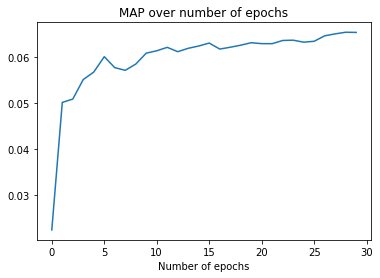

In [153]:
plt.plot(NN_MAP_plotting)
plt.title("MAP over number of epochs")
plt.xlabel("MAP")
plt.xlabel("Number of epochs")
plt.show()

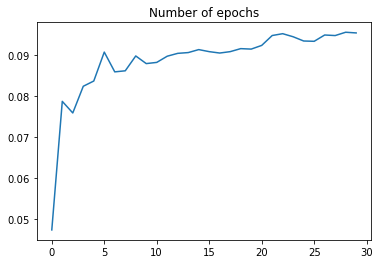

In [154]:
plt.plot(NN_MnDCG_plotting)
plt.title("MnDCG over number of epochs")
plt.title("MnDCGs")
plt.title("Number of epochs")
plt.show()

Running against testing queries and saving File:

In [171]:
testing_NN= np.zeros((len(testing_filtered_passages_per_query),len(testing_filtered_passages_per_query[0])))

for q in range(len(testing_filtered_passages_per_query)): 
    
    testing_passage_vectors = GetEmbeddings(model,testing_filtered_passages_per_query[q],temp_testing_p[q])
             
        
    testing_features= abs(testing_query_vectors[q] - testing_passage_vectors)
    
    #V_Q= np.tile(testing_query_vectors[q],(testing_passage_vectors.shape[0],1))
    #testing_features_600= np.hstack((V_Q,testing_passage_vectors))
    
    NN_y_hat = torch.as_tensor(testing_features)

    y_hat = NN_model(NN_y_hat.float())
    
    testing_NN[q,0:testing_passage_vectors.shape[0]]= y_hat.detach().numpy().flatten()

In [172]:
N=100
top_scores_NN,top_qids_NN,top_pids_NN = GenerateNRanking(testing_NN,N,testing_passages_id_per_query,query_ids)

In [173]:
Compare= 4

print("Query: ")
print(test_queries[np.where(test_queries[:,0]==top_qids_NN[Compare][0]),1])
print("\n")
print("Top NN on txt file: ")
print(testing_set[np.where(testing_set[:,1]==top_pids_NN[Compare][0]),3])

print(top_scores_NN[Compare][0])

Query: 
[['where is steph currys home in nc']]


Top NN on txt file: 
[['Steph Curry’s mom Sonya Curry. Steph Curry’s mom (and Dell Curry’s wife), Sonya Curry, is the heart and soul of the Curry cheering section. This cheering section also extends to Seth Curry, a Duke alumni who now plays for the Sacramento Kings. Dell Curry’s wife attended Virginia Tech back in the 80’s.']]
0.25061556696891785


In [174]:
SaveFile(top_scores_NN,top_qids_NN,top_pids_NN,"NN")

<ipython-input-8-a2db46748247>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  qids= np.array(total_qid)
<ipython-input-8-a2db46748247>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pids= np.array(total_pids)
<ipython-input-8-a2db46748247>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scores= np.array(total_scores)
